# Find a model for the reccomendation system

What we want to obtain is a model with which we can suggest the most suited page for the user. To do this we look for that model which obtain the highest accuracy at the smallest train time. This because we will need to train one model for each user at every fixed amount of feedbacks.

## Imports

In [1]:
import pandas as pd
import numpy as np

from helper import get_training_data

from sklearn.linear_model import LogisticRegression
from sklearn.tree         import DecisionTreeClassifier
from sklearn.svm          import SVC
from sklearn.naive_bayes  import GaussianNB

from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

from time import time

import pickle as pkl

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

np.random.seed(0)

ModuleNotFoundError: No module named 'helper'

## Preprocess

Load the .csv file as a Pandas DataFrame

In [ ]:
user = "Stefano"
X, y = get_training_data(user)

The DataFrame contains the title of the page, the related bag of words contained in the Wikipedia page.

In [ ]:
pages_df.head()

,TITLE,the,of,and,to,a,in,for,is,on,...,robbie,stake,cocktail,outlets,swaziland,varieties,arbor,mediawiki,configurations,poison
0,linear algebra,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,True,False,False,False
1,math,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,True,False
2,japan,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
3,Congress of Deputies,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
4,madrid,True,True,True,True,True,True,True,True,True,...,False,False,True,False,False,False,False,False,False,False


 To test the trained models we will use the score variable (dislike=0, like=1) that the user gave to the visited page.

In [ ]:
user_df = pd.read_csv("/content/drive/MyDrive/MLOps/user.csv", sep='\t')
user_df = user_df.drop_duplicates()

In [ ]:
idx = [pages_df[pages_df['TITLE'] == title].index[0] for title in user_df["TITLE"]]

In [ ]:
y = user_df["SCORE"].values
X = pages_df.drop(["TITLE"], axis=1).values[idx]

# Test Models

The selected models which will be tested are:
- Logistic Regression
- Decision Tree
- Linear Support Vector Classifier
- Support Vector Classifier
- Gaussian Naive Bayes

We train them and keep track of the accuracies, the f1-scores, the elapsed time for the training and the elapsed time for the predictions.

Because we want to obtain a score and not a classification of the pages (The suggested pages will be ranked based on the scores) we decided to keep only the algorithms which contains the method:

```
# clf.predict_proba(X_test)
```

Which will return the probability that an element is inside a class. For this reason the new algorithms which will be tested are:
- Logistic Regression
- Decision Tree
- Support Vector Classifier
- Gaussian Naive Bayes


### Train

#### Function

Function to train the models specified in input. The returns are the trained models, the accuracies, the f1-scores, the train elapsed to train them, the time elapsed to predict the test set

In [ ]:
def train_models(to_train, cv, X, y):
    # Split the data in train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    models        = []
    accuracies    = []
    f1_scores     = []
    train_times   = []
    predict_times = []

    for model in to_train:
        # Train the model and keep the times
        start_train = time()
        clf = model.fit(X_train, y_train)
        end_train = time()

        # Make the prediction and keep the times
        start_pred = time()
        pred = clf.predict(X_test)
        end_pred = time()

        # Calculate the mean of the accuracies for the algorithm
        k_fold_accuracy_mean = np.mean(cross_val_score(clf, X, y, cv=cv))
        # Calculate the mean of the f1-scores for the algorithm
        k_fold_f1_scores     = np.mean(cross_val_score(clf, X, y,
                                      cv=cv,
                                      scoring=make_scorer(f1_score, average='weighted')))

        # Append the informations
        models       .append(clf)
        accuracies   .append(round( k_fold_accuracy_mean, 3 ))
        f1_scores    .append(round( k_fold_f1_scores, 3 ))
        train_times  .append(end_train - start_train)
        predict_times.append(end_pred - start_pred)

    return models, accuracies, f1_scores, train_times, predict_times

#### Train phase

In [ ]:
to_train = [LogisticRegression(), DecisionTreeClassifier(), SVC(), GaussianNB()]

In [ ]:
models, accuracies, f1_scores, train_times, predict_times = train_models(to_train, 10, X, y)

## Results

### Results table

All the information are inserted inside a pandas dataframe to get a better visualization of the results. From this results we can notice that the models which require least time to train is the Gaussian Naive Bayes while the worst is the Support Vector Classifier.

The best accuracy is given by the Support Vector Classifier and the worst is given by the Gaussian Naive Bayes.

The Decision Tree Classifier is discarded because the predicted probabilities returned from the model are just zeros and ones. This is due by the overfitting approach of the model. Even if the pruning can be applied the Logistic Regression and the Support Vector Classifier give us good enough results.

The Support Vector Classifier has a really slow prediction time, for this reason we prefer the Logistic Regression.

In [ ]:
algorithm_names=["Logistic Regression", "Decision Tree", "Support Vector Classifier", "Gaussian Naive Bayes"]

In [ ]:
data = np.array([accuracies, f1_scores, train_times, predict_times]).T

results_df = pd.DataFrame(data,
                          columns=["Accuracy", "f1-score", "train-time", "predict-time"],
                          index=algorithm_names)
results_df

,Accuracy,f1-score,train-time,predict-time
Logistic Regression,0.877,0.874,1.611882,0.013809
Decision Tree,0.785,0.787,0.688171,0.001440
Support Vector Classifier,0.877,0.876,0.266031,0.103515
Gaussian Naive Bayes,0.645,0.611,0.048347,0.010662


# Plot Times

We are interested on create a model for each user every **n** feedbacks, then we want to be sure that the previous models can scale easily. For this reason we simulate a training on really big datasets.

### Function

Function to plot the times given in input

In [ ]:
def plot_times(df, model):
    df[model].plot(kind='line', figsize=(8, 4), title="Algorithms times")
    plt.gca().spines[['top', 'right']].set_visible(False)

Function to generate dataset with the same columns but number of row from $N$ to $N+10000$ adding $1000$ row at time.

In [ ]:
def enlarge_dataset(X, y):
    enlarged_data          = [(X, y)]
    X_enlarged, y_enlarged = X, y

    for n in range(1000, 11000, 1000):
        idxs = np.random.choice(range(len(X)), 1000)
        X_enlarged = np.array(X_enlarged.tolist() + X[idxs].tolist())
        y_enlarged = np.array(y_enlarged.tolist() + y[idxs].tolist())

        enlarged_data.append((X_enlarged, y_enlarged))

    return enlarged_data

Function to get the train times of the different enlarged datasets given in input for the specified model.

In [ ]:
def get_times(model, enlarged_data):
    train_times = []
    pred_times  = []

    for X_enlarged, y_enlarged in enlarged_data:
        start_train   = time()
        clf           = model.fit(X_enlarged, y_enlarged)
        end_train     = time()

        train_times   += [end_train - start_train]

        start_predict = time()
        clf.predict(X_enlarged)
        end_predict   = time()

        pred_times    += [end_predict - start_predict]

    return train_times, pred_times

### Get times

In [ ]:
enlarged_data = enlarge_dataset(X, y)

In [ ]:
LR_times, LR_pred_times     = get_times(LogisticRegression(), enlarged_data)
DT_times, DT_pred_times     = get_times(DecisionTreeClassifier(), enlarged_data)
SVC_times, SVC_pred_times   = get_times(SVC(), enlarged_data)
GNB_times, GNB_pred_times   = get_times(GaussianNB(), enlarged_data)

In [ ]:
train_data = np.array([LR_times, DT_times, SVC_times, GNB_times]).T
pred_data  = np.array([LR_pred_times, DT_pred_times, SVC_pred_times, GNB_pred_times]).T

### Results

In [ ]:
algorithm_names=["Logistic_regression", "Decision Tree", "Support Vector Classifier", "Gaussian Naive Bayes"]

#### Tables

In [ ]:
train_times_df = pd.DataFrame(train_data,
                              columns=algorithm_names,
                              index=range(0 + len(X), 11000 + len(X), 1000))
train_times_df

,Logistic_regression,Decision Tree,Support Vector Classifier,Gaussian Naive Bayes
358,1.494793,0.364784,0.377835,0.046407
1358,3.977731,2.116900,3.952157,0.204577
2358,5.170199,2.948977,7.326231,0.416074
3358,8.134236,3.396771,13.442176,0.577244
4358,9.237333,7.794653,22.697737,0.884708
5358,12.277479,5.147181,29.856381,1.121727
6358,14.085081,8.627507,36.885238,1.348610
7358,15.392395,6.874883,48.054938,1.326766
8358,18.748524,5.313147,50.889037,1.406276
9358,22.511461,8.024913,66.838120,1.589218


In [ ]:
pred_times_df = pd.DataFrame(pred_data,
                             columns=algorithm_names,
                             index=range(0 + len(X), 11000 + len(X), 1000))
pred_times_df

,Logistic_regression,Decision Tree,Support Vector Classifier,Gaussian Naive Bayes
358,0.016288,0.004633,0.726128,0.033189
1358,0.077114,0.012826,5.172656,0.182571
2358,0.136052,0.035692,11.010036,0.310380
3358,0.201338,0.075392,26.512456,0.436549
4358,0.155225,0.080117,37.010667,0.696631
5358,0.212558,0.099554,43.328908,0.844811
6358,0.284496,0.275758,58.396436,0.989221
7358,0.307944,0.104934,62.216455,0.957982
8358,0.411127,0.118836,78.021067,1.091851
9358,0.496379,0.133516,86.471439,1.229219


#### Plots

We can notice that the models scale consistently to the previous results. Then we can select the logistic regression model for its good results between accuracy and train/predict time. Even if the Support Vector Machine has obtaind good results the large predict time make us discard it. The reason is that the prediction will be a recurrent request which the users will do, then it is necessary that the results are given in a reasonable amount of time

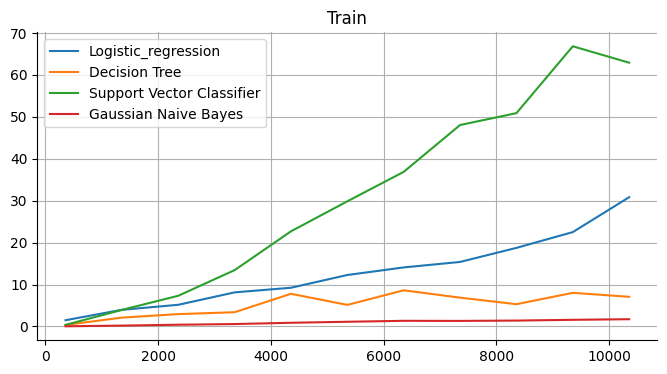

In [ ]:
for model in algorithm_names:
   plot_times(train_times_df, model)

plt.grid()
plt.title("Train")
plt.legend()
plt.show()

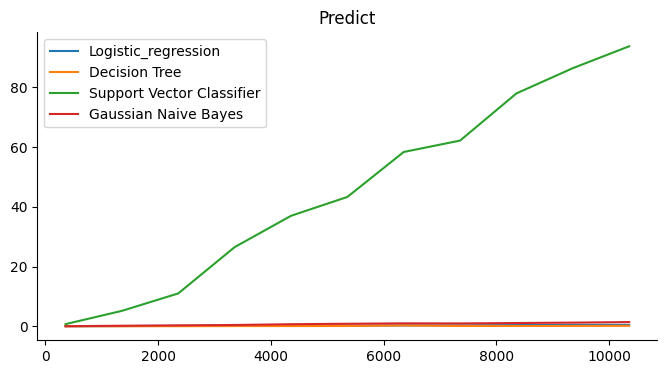

In [ ]:
for model in algorithm_names:
   plot_times(pred_times_df, model)

plt.title("Predict")
plt.legend()
plt.show()

# Grid Search

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Default

To determine which parameters are the best we take the default model as the baseline to compare the results

In [ ]:
LR = LogisticRegression().fit(X_train, y_train)

In [ ]:
LR.score(X_test, y_test)

0.8611111111111112

In [ ]:
LR.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

#### Grid Search Solver

In [ ]:
parameters = {'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}
clf = GridSearchCV(LogisticRegression(), parameters).fit(X_train, y_train)

In [ ]:
clf.best_estimator_.score(X_test, y_test)

0.8333333333333334

In [ ]:
clf.best_params_


{'solver': 'lbfgs'}

#### Grid Search LR

Using the Grid Search approach we try different combination of parameters to understand which parameters are the best.

In [ ]:
parameters = {'penalty':[None, 'l1', 'l2'], 'C':[1, 10, 100], 'class_weight':['balanced', 'None'], 'max_iter':[1000, 2000, 3000], 'tol':[0.1, 0.01, 0.001, 0.0001]}
clf = GridSearchCV(LogisticRegression(), parameters).fit(X_train, y_train)

In [ ]:
clf.best_estimator_.score(X_test, y_test)

0.8611111111111112

In [ ]:
clf.best_params_

{'C': 1,
 'class_weight': 'balanced',
 'max_iter': 1000,
 'penalty': None,
 'tol': 0.1}

In [ ]:
parameters = {'C':[1, 10],  'class_weight':['balanced', 'None', {0.6, 0.4}], 'max_iter':[1000, 2000, 3000], 'tol':[0.1, 0.01, 0.001, 0.0001]}
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters).fit(X_train, y_train)

In [ ]:
clf.best_estimator_.score(X_test, y_test)

0.8611111111111112

In [ ]:
clf.best_params_

{'C': 10, 'class_weight': 'balanced', 'max_iter': 1000, 'tol': 0.01}

What we can notice is that the best solutions found have the same results of the default model. This means that we can even keep the default model to keep the train simplier without lose informations.

### Feature Importance

As last step we could be interest in what words are significant to keep. This because if none of the user's models use some words, then keep these words make the complexity of the models higher than the needed one. To determine which words can be removed we can analize the coefficients of the Logistic Regression model. This process should be done with an higher number of models otherwise we are just determining which words are not used by a single user. This process could be useful also for trasparency showing why a page was suggested to a specific user.

#### LR Feature importance

Take the 20 words wich affect the least the decision

In [ ]:
idxs = np.argsort(np.abs(LR.coef_))[0][:20]

In [ ]:
name_min = pages_df.columns[2:][idxs]
val_min = LR.coef_[0][idxs]

In [ ]:
[(name, val) for name, val in zip(name_min, val_min)]

[('neo', 0.0),
 ('plates', 0.0),
 ('entities', 0.0),
 ('trans', 0.0),
 ('apparatus', 0.0),
 ('outcomes', 0.0),
 ('sheer', 0.0),
 ('pens', 0.0),
 ('removing', 0.0),
 ('reel', 0.0),
 ('jaguar', 0.0),
 ('cayman', 0.0),
 ('challenge', 0.0),
 ('rangers', 0.0),
 ('attach', 0.0),
 ('feelings', 0.0),
 ('merchant', 0.0),
 ('arrest', 0.0),
 ('charging', 0.0),
 ('dv', 0.0)]

Take the 20 pages which affect the most the decision (positively and negatively)

In [ ]:
idxs = np.argsort(np.abs(LR.coef_))[0][-20:][::-1]

In [ ]:
name_max = pages_df.columns[2:][idxs]
val_max = LR.coef_[0][idxs]

In [ ]:
[(name, val)for name, val in zip(name_max, val_max)]

[('from', 0.36743418420231677),
 ('be', 0.3365965134434953),
 ('dc', 0.3305570083415603),
 ('they', 0.28176048199355785),
 ('do', 0.25910013707627),
 ('have', 0.2510901881858558),
 ('county', 0.24215771403541878),
 ('men', 0.2269303781400369),
 ('what', 0.22683864463894896),
 ('views', 0.21585776748417795),
 ('tool', 0.2125758245315307),
 ('service', 0.21139743370149017),
 ('with', 0.20401138954673087),
 ('these', 0.20056900261537206),
 ('ui', 0.19429762650055366),
 ('compare', 0.19363608412315753),
 ('reports', 0.19081860697291667),
 ('unless', -0.1905678081239282),
 ('short', 0.19004784438628158),
 ('site', 0.18918123238080622)]

Save the information into a file

In [ ]:
data = np.array([pages_df.columns[3:], LR.coef_[0]]).T
df = pd.DataFrame(data,
                  columns=["word", "weight"])
df.to_csv("/content/drive/MyDrive/MLOps/LR_weight.csv", sep='\t', index=False)